<a href="https://colab.research.google.com/github/desiredominique/xception_ml/blob/main/MNIST_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importação dos bancos do tensorflow

!pip install -U tensorflow_datasets

In [2]:
from __future__ import absolute_import, division, print_function

In [3]:
# importação dos pacotes

import tensorflow as tf
import tensorflow_datasets as tfds

import math
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
# importando os dados para o colab
dataset, metadata = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteCYLCFU/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteCYLCFU/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
# introduzindo as classes
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [6]:
# separação dos dados de treinamento e teste
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Número de arquivos para treinamento: {}".format(num_train_examples))
print("Número de arquivos para teste {}".format(num_test_examples))

Número de arquivos para treinamento: 60000
Número de arquivos para teste 10000


In [7]:
# função de normalização para 0,1 ao invés de 0,255

def normalize(images,labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images,labels

  train_dataset = train_dataset.map(normalize)
  test_dataset = test_dataset.map(normalize)

  train_dataset = train_dataset.cache()
  test_dataset = test_dataset.cache()

In [8]:
# montando as camadas da rede
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), #transforma as imagens uma matriz 2d de 28x28 pixels em uma de 1d com 784 pixels(28x28)
    tf.keras.layers.Dense(128,activation=tf.nn.relu), #camada oculta densa com 128 neurônios, cada neuronio pega as entradas dos 784 pixels na camada anterior, pesando essa entrada de acordo com parametros que serao aprendidos durante o treinamento
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) #128 neuronios, seguidos por uma camada de 10 nós. Cada nó representa uma classe. Como na camada anterior, a camada final pega as entradas dos 128 nós na camada antes disso, e saem um valor no intervalo [0,1], representando a probabilidade da imagem pertencer à classe. O resumo do valor dos 10 nós é 1
])

In [9]:
# compilação do modelo

model.compile(optimizer= 'adam', #algoritmo que ajusta parametros internos do modelo para minimizar a perda
              loss= tf.keras.losses.SparseCategoricalCrossentropy(), #algoritmo para mensurar quão longe as saídas do modelo estão da saída desejada. O objetivo do treinamento é mensurar a perda.
              metrics = ['accuracy'] #monitora os passos do treinamento e teste
)

In [10]:
# iteração da base de treinamento
BATCH_SIZE = 32 #utiliza lotes de 32 imagens e rótulos quando atualizadas as variaveis do modelo
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE) #randomiza a ordem então o modelo não pode aprender nada dos exemplos
test_dataset = test_dataset.cache().batch(BATCH_SIZE) #.batch diz para o model.fit para usar lotes de 32 imagens

In [11]:
# treinamento do modelo
model.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

1875/1875 [==============================] - 13s 3ms/step - loss: 4.1089 - accuracy: 0.6785


In [ ]:
# avaliação da acurácia
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print("Acurácia do teste da base de dados:", test_accuracy)

RuntimeError: ignored

In [ ]:
# predições
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 82ms/step


In [ ]:
# forma das predições
predictions[0] # matriz de 10 numeros

array([5.5856542e-03, 3.5179154e-10, 3.2631893e-02, 1.7391679e-04,
       5.3965718e-01, 1.4567266e-12, 4.2194727e-01, 6.0699039e-34,
       4.1394646e-06, 3.0923733e-26], dtype=float32)

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

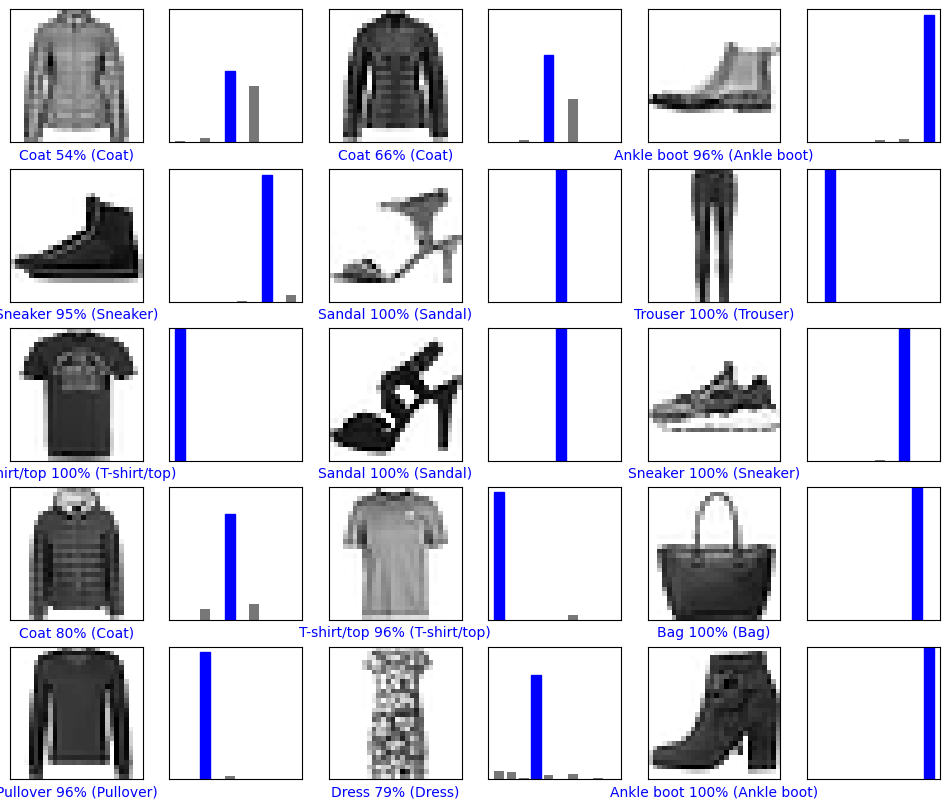

In [ ]:
# plotar imagens com suas prediçoes, predições corretas (verde), predições incorretas (vermelho), o numero apresenta o percentual para a predição
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [ ]:
# utilizando o modelo treinado para fazer predições sobre uma imagem
# pegndo uma imagem do banco de teste
img = test_images[0]
print(img.shape)

(28, 28, 1)


In [ ]:
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


In [ ]:
# predição de uma imagem
predictions_single = model.predict(img)
print(predictions_single)

1/1 [==============================] - 0s 23ms/step
[[5.5856565e-03 3.5179218e-10 3.2631889e-02 1.7391694e-04 5.3965718e-01
  1.4567294e-12 4.2194724e-01 6.0699502e-34 4.1394687e-06 3.0923730e-26]]


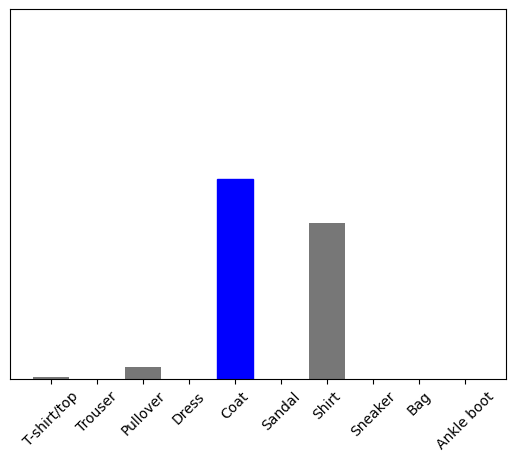

In [ ]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [ ]:
np.argmax(predictions_single[0])

4